In [4]:
from core.metrics import *
from core.semcor_bert_pipeline import load_data, get_pos
from core.analysis import *
from sklearn.manifold import MDS
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

<Figure size 432x288 with 0 Axes>

## MDS on Centroids of Shared Words

In [5]:
shared_words = ['foot', 'table', 'plane', 'degree', 'right', 'model']
with open('../data/stimuli.json') as f:
    db = json.load(f) #Some senses that were logged were not used in expt

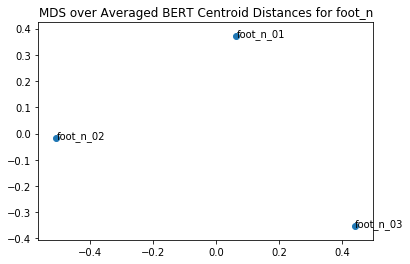

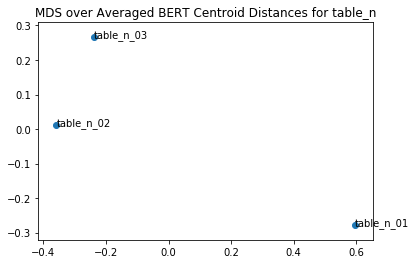

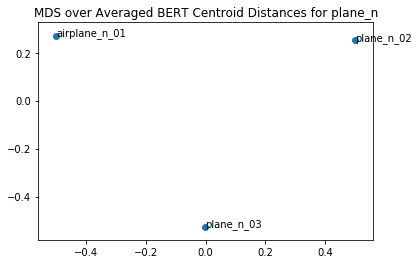

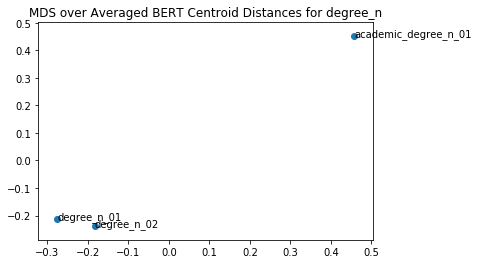

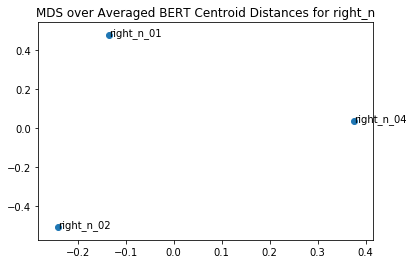

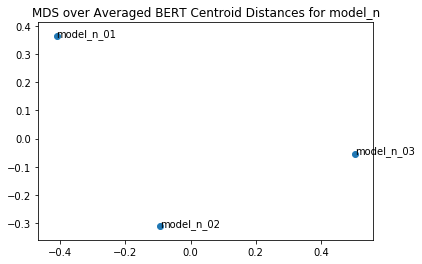

In [4]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w, 'n',sel_senses = [fb_to_local(s) for s in get_senses(db, w + "_n")],
                                            use_masc = True, normalize = True)
    mds_model = MDS(n_components = 2, dissimilarity = 'precomputed')
    plot_mds(result_mtx, w + '_n', mds_model, db, "BERT Centroid")

## Distances for Homonymous and Polysemous Sense Pairs

We first extract the pairs, then compute the distances from the centroids of each sense pair, plot the results, and finally run a test for statistical significance.

In [71]:
sense_pair_dists = pd.read_csv('../data/sense_pair_distances.csv')
sense_pairs = sense_pair_dists[['item', 'word_type', 'relation_type']].drop_duplicates()

In [72]:
sense_pairs['item'] = sense_pairs['item'].apply(sense_pair_as_tuple)

Compute pairwise distances between centroids of BERT embeddings.

In [75]:
distances = []
for l in sense_pairs['word_type'].unique(): #Iterating over types
    word, pos = l.split('_')
    #Loading data & declaring vars
    word_data = semcor_bert_pipeline.load_data(word, pos, 'semcor')
    word_dists = np.array([])
    max_dist = 0 #We keep track of this to normalize at the end
    word_pairs = sense_pairs[sense_pairs['word_type'] == l]['item'] #Items for each type
    sense_labels = np.array(word_data['sense_labels']) #
    embeddings = np.array(word_data['embeddings'])
    for p in word_pairs:
        #Finding embeddings for each sense in the pair
        s1 = p[0]
        s2 = p[1]
        s1_indices = np.argwhere(sense_labels == s1).flatten()
        s2_indices = np.argwhere(sense_labels == s2).flatten()
        s1_embeddings = embeddings[s1_indices]
        s2_embeddings = embeddings[s2_indices]
        #Computing centroids
        dist = 1 - cs_centroids(s1_embeddings, s2_embeddings)
        if dist > max_dist:
            max_dist = dist
        word_dists = np.append(word_dists, dist)
    word_dists /= max_dist
    distances += word_dists.tolist()

In [91]:
sense_pairs['dist'] = 1 - np.asarray(distances)
sense_pairs

,item,word_type,relation_type,dist
0,"(foot.n.01, foot.n.02)",foot_n,homonymous,0.297825
1,"(foot.n.01, foot.n.03)",foot_n,polysemous,0.165074
2,"(foot.n.02, foot.n.03)",foot_n,homonymous,0.000000
282,"(table.n.01, table.n.02)",table_n,homonymous,0.000000
283,"(table.n.01, table.n.03)",table_n,polysemous,0.075249
...,...,...,...,...
6393,"(homo.n.02, man.n.03)",man_n,polysemous,0.727959
6394,"(homo.n.02, serviceman.n.01)",man_n,polysemous,0.000000
6395,"(man.n.01, man.n.03)",man_n,polysemous,0.772925
6396,"(man.n.01, serviceman.n.01)",man_n,polysemous,0.629653


In [92]:
hom_dists = sense_pairs[sense_pairs['relation_type'] == 'homonymous']['dist']
pol_dists = sense_pairs[sense_pairs['relation_type'] == 'polysemous']['dist']

In [93]:
sense_pairs[sense_pairs['relation_type'] == 'homonymous']

,item,word_type,relation_type,dist
0,"(foot.n.01, foot.n.02)",foot_n,homonymous,0.297825
2,"(foot.n.02, foot.n.03)",foot_n,homonymous,0.000000
282,"(table.n.01, table.n.02)",table_n,homonymous,0.000000
284,"(table.n.02, table.n.03)",table_n,homonymous,0.697890
564,"(airplane.n.01, plane.n.02)",plane_n,homonymous,0.000000
565,"(airplane.n.01, plane.n.03)",plane_n,homonymous,0.011184
846,"(academic_degree.n.01, degree.n.01)",degree_n,homonymous,0.000000
847,"(academic_degree.n.01, degree.n.02)",degree_n,homonymous,0.069127
1128,"(right.n.01, right.n.02)",right_n,homonymous,0.000000
1129,"(right.n.01, right.n.04)",right_n,homonymous,0.327423


Plotting human distances with these

In [94]:
human_pair_dists = pd.read_csv('../data/sense_pair_distances.csv')
human_pair_dists['dist'] = 1 - human_pair_dists['dist']
agg_human_dists = pd.DataFrame(human_pair_dists.groupby(['item', 'relation_type']).dist.agg('mean')).reset_index()
human_hom = agg_human_dists[agg_human_dists['relation_type'] == 'homonymous']['dist']
human_pol = agg_human_dists[agg_human_dists['relation_type'] == 'polysemous']['dist']

In [95]:
plt.rcParams["font.family"] = "Times New Roman"

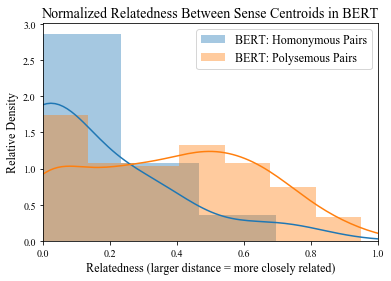

In [97]:
sns.distplot(hom_dists, label = "BERT: Homonymous Pairs")
sns.distplot(pol_dists, label = "BERT: Polysemous Pairs")
plt.xlim(0, 1)
plt.xlabel("Relatedness (larger distance = more closely related)", fontsize = 12)
plt.ylabel("Relative Density", fontsize = 12)
plt.legend(fontsize = 12)
plt.title("Normalized Relatedness Between Sense Centroids in BERT", fontsize = 14)
plt.savefig("../../results/figures/bert_ph_dist.png")

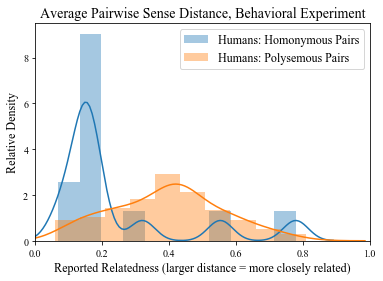

In [98]:
sns.distplot(human_hom, label = "Humans: Homonymous Pairs")
sns.distplot(human_pol, label = "Humans: Polysemous Pairs")
plt.xlim(0, 1)
plt.xlabel("Reported Relatedness (larger distance = more closely related)", fontsize = 12)
plt.ylabel("Relative Density", fontsize = 12)
plt.legend(fontsize = 12)
plt.title("Average Pairwise Sense Distance, Behavioral Experiment", fontsize = 14)
plt.savefig("../../results/figures/human_ph_dist.png")

Because the distributions have a left tail, we use the medians as a measure of center.

In [228]:
np.median(hom_dists)

0.9654364126272177

In [229]:
np.median(pol_dists)

0.6225331147193638

We use a non-parametric test (Mann-Whitney) because of the left tail

In [83]:
stats.mannwhitneyu(hom_dists, pol_dists)

MannwhitneyuResult(statistic=516.0, pvalue=0.0014325283836538354)

In [84]:
stats.mannwhitneyu(human_hom, human_pol)

MannwhitneyuResult(statistic=493.0, pvalue=0.0009674786627642584)


## Comparing with Experiment Results- Shared Trials

First, we plot matrices for the shared words side by side, then we compute correlations between human reported and BERT cosine distances for the shared trials (words with one homonymous/2 polysemous senses). They are plotted against a random baseline.

In [8]:
results = pd.read_csv("../data/approved_expt_results.csv")

In [9]:
incl_users = results['userID'].unique()

### Shared Word Comparison

In [10]:
import itertools

foot_n (0.15731890617067046, 0.8994298882580638)
table_n (0.9967862634840645, 0.05105245510975999)
plane_n (0.9851032396308168, 0.11002253492042172)
degree_n (0.9902957171365865, 0.08876232726965794)
right_n (0.859962246511769, 0.3409739533761255)
model_n (0.9956153519937113, 0.059637757052140625)


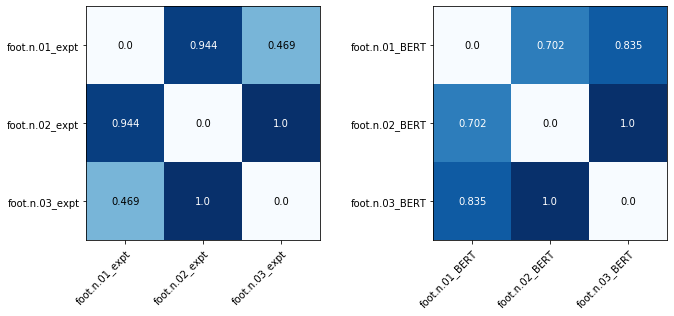

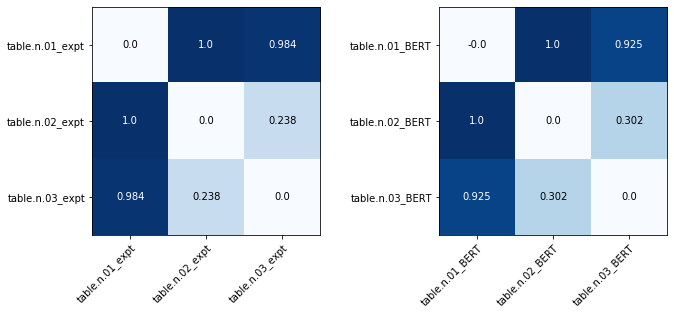

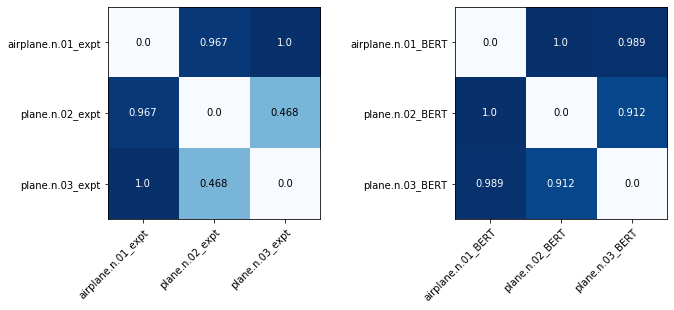

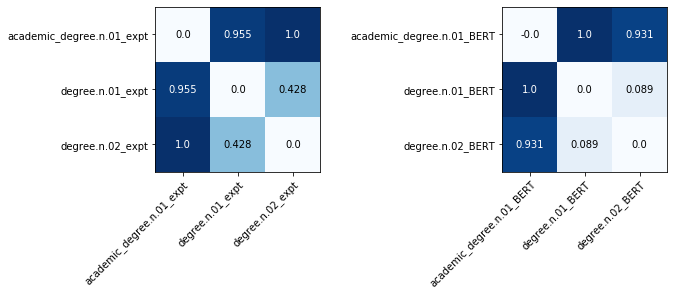

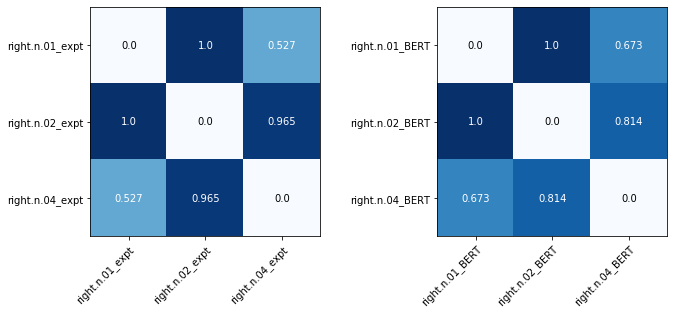

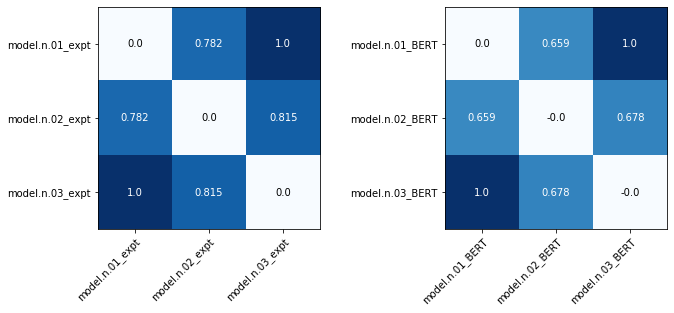

In [11]:
shared_words = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']
matrices = {w: {} for w in shared_words}

#print("Spearman Rank Correlations for Shared Words")
for w in shared_words:
    expt_means = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_means
    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                          use_masc = False)
    matrices[w]['sense_pairs'] = [str(c) for c in list(itertools.combinations([fb_to_local(s) for s in get_senses(db, w)], 2))]
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs
    print(w, mtx_correlation([matrices[w]['bert']], [matrices[w]['expt']], method = 'pearson'))
    fig = plt.figure(figsize = (10, 10))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    im1 = ax1.imshow(expt_means)
    annotate_mtx(expt_means, im1, ax1, [s + "_expt" for s in sense_names])
    im2 = ax2.imshow(bert_cs)
    annotate_mtx(bert_cs, im2, ax2, [s + '_BERT' for s in sense_names])
    fig.tight_layout(pad = 3.0)


### Correlation for Shared Words

In [12]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [17]:
all_human_avg = [matrices[w]['expt'] for w in shared_words]
all_bert_cs = [matrices[w]['bert'] for w in shared_words]
sense_pairs = flatten([matrices[w]['sense_pairs'] for w in shared_words])
bert_human_shared, human, bert = mtx_correlation(all_human_avg, all_bert_cs, return_ut = True)
bert_human_shared

SpearmanrResult(correlation=0.8072805139186296, pvalue=5.123250697632021e-05)

BERT and human results are highly correlated. We compare it to the correlations between human data and 1000 randomly generated placements.

In [43]:
import seaborn as sns

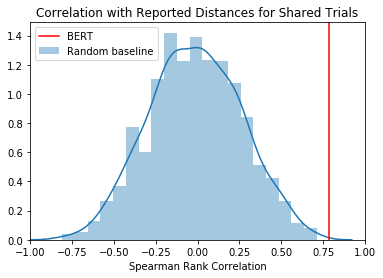

In [234]:
random_vs_human = [mtx_correlation([create_random_symmetric_mtx() for i in range(len(shared_words))],
                          all_human_avg)[0] for i in range(1000)]
sns.distplot(random_vs_human)
plt.axvline(bert_human_shared[0], color = 'red')
plt.title("Correlation with Reported Distances for Shared Trials")
plt.xlim(-1, 1)
plt.xlabel("Spearman Rank Correlation")
plt.legend(["BERT", "Random baseline"])
plt.savefig("../../results/figures/shared_random.png")

## Full Experiment Results

We take the correlation between human reported distances and BERT cosine distances for all stimuli, comparing to a random baseline.

In [99]:
test_results = results[results['trialType'] == 'test']
users = results['userID'].unique()
test_matrices = {w: {} for w in test_results['lemma'].unique()}

for w in test_matrices.keys():
    test_matrices[w] = mean_distance_mtx(results, w, 'test', users, normalize = True)

In [101]:
responses_per_type = int(np.round(np.mean(test_results.groupby('lemma').userID.agg(lambda s:
                                                                                    len(np.unique(s)))), 0))
shared_results = results[results['trialType'] == 'shared']
shared_lst = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']


In [102]:
target_words = pd.concat([test_results, shared_results])['lemma'].unique()
bert_matrices = {w: {} for w in target_words}

for w in target_words:
    word, pos = w.split('_')
    bert_matrices[w] = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)], use_masc = False,
              normalize = True)[0]

In [103]:
all_bert_cs = [bert_matrices[w] for w in bert_matrices.keys()]
test_bert_cs = [bert_matrices[w] for w in bert_matrices.keys() if w not in shared_lst]
test_human_avg = [test_matrices[w] for w in test_matrices.keys()]

In [104]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


In [108]:
user_sample = np.random.choice(users, int(responses_per_type), replace = True)
shared_resampled = []

for l in shared_lst:
    shared_for_type = shared_results[shared_results['lemma'] == l]
    i = 0
    for u in user_sample:
        user_data = shared_for_type[shared_for_type['userID'] == u]
        user_data['userID'] = i
        shared_resampled.append(user_data)
        i += 1

downsampled_shared = pd.concat(shared_resampled)

downsampled_shared_matrices = {w: {} for w in shared_lst}

for w in downsampled_shared_matrices.keys():
    downsampled_shared_matrices[w] = mean_distance_mtx(downsampled_shared, w, 'shared', downsampled_shared['userID'].unique(),
                                           normalize = True)

human_matrices = dict(list(test_matrices.items()) + list(downsampled_shared_matrices.items()))
all_human_avg = [human_matrices[w] for w in human_matrices.keys()]
test_human_avg = [test_matrices[w] for w in test_matrices.keys()]
bert_human_all = mtx_correlation(all_human_avg, all_bert_cs)
bert_human_all

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


SpearmanrResult(correlation=0.5579026617273543, pvalue=7.453810249510021e-17)

Looking at stimuli with only polysemous senses

In [110]:
test_corr = mtx_correlation(test_human_avg, test_bert_cs)
test_corr

SpearmanrResult(correlation=0.5546943395771994, pvalue=3.4944895519038967e-15)

In [113]:
random = []
for _ in tqdm(list(range(1000))):    
    random_avg = []
    for w in human_matrices.keys():
        avg_dim = np.mean([create_random_symmetric_mtx(get_num_senses(w, db)) for _ in range(responses_per_type)], axis = 0)
        random_avg.append(avg_dim / np.max(avg_dim))
    random_placement = mtx_correlation(random_avg, all_human_avg, method = 'spearman')[0]
    random.append(random_placement)

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [114]:
np.mean(random)

0.06465527710400065

In [115]:
print("95% Confidence Interval for Random Baseline", (np.percentile(random, 2.5), np.percentile(random, 97.5)))

95% Confidence Interval for Random Baseline (-0.07452165667610947, 0.20191965832651618)


## Previous work

In [238]:
test_repeat_words = lemma_counts[lemma_counts['num_trials'] > 12]['lemma']
for w in test_repeat_words:
    matrices[w] = {} #defined when we had shared words
    word, pos = w.split('_')
    matrices[w]['sense_pairs'] = [str(c) for c in list(itertools.combinations([fb_to_local(s) for s in get_senses(db, w)], 2))]
    cs_mtx, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    use_masc = True, normalize = True)
    matrices[w]['bert'] = cs_mtx
    matrices[w]['expt'] = get_test_result_data(results, w, incl_users)


In [242]:
all_human_avg = [matrices[w]['expt'] for w in matrices.keys()]
all_bert_cs = [matrices[w]['bert'] for w in matrices.keys()]
all_sense_pairs = flatten([matrices[w]['sense_pairs'] for w in matrices.keys()])
bert_human_all, human, bert = mtx_correlation(all_human_avg, all_bert_cs, return_ut = True)

bert_human_all

SpearmanrResult(correlation=0.5445426730158504, pvalue=5.517799117449513e-16)

BERT embeddings and human results for these stimuli are less correlated than the shared stimuli.

In [236]:
all_words = test_repeat_words.tolist() + results[results['trialType'] == 'shared']['lemma'].unique().tolist()

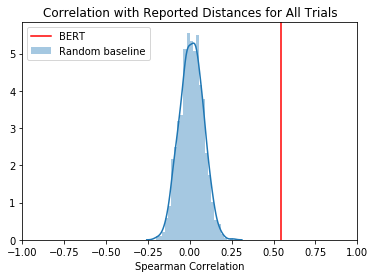

In [243]:
permuted_bert_entries = [mtx_correlation([(get_num_senses(w, db)) for w in all_words], 
                                         all_human_avg,
                                         method = 'spearman')[0] for i in range(1000)]


sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_all[0], color = 'red')
plt.xlim(-1, 1)
plt.title("Correlation with Reported Distances for All Trials")
plt.xlabel("Spearman Correlation")
plt.legend(["BERT", "Random baseline"])
plt.savefig("../../results/figures/all_random.png")